# KPI Revenue

## Libraries

In [8]:
# importing all relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from matplotlib.dates import date2num

## Styles

In [9]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)

## Data reading

In [10]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    return trip_data

## KPI generation

### Read in data

In [60]:
#
# TASK: CALCULATE REVENUE PER BIKE FOR BOTH CITIES BREMEN AND DÜSSELDORF
#       CALCULATE KPI HOURLY, VISUALIZE OVER TIME (DAY, WEEK, MONTH)
#

def generate_revenue_per_hour_for_city(data, city, start_date, end_date):
    '''
    Generates plots of revenue per hour, summed, and revenue per hour, on average,
    for a given city and time frame. For each city 4 plots are generated, 2 of those scatter plots
    and 2 line plots, plotting both KPI's, respectively.

    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    '''

    # sorting and key stats of data
    dat = data.sort_values(by=['datetime_start'], axis=0)

    def calc_revenue(x):
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # count trip duration intervals for each trip, i.e. how much revenue each trip generated,
    # by setting the revenue to 1 plus the number of 30-minute durations fitting into the trip duration
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))

    # SET TIME WINDOW FOR HOURLY GROUPING OF VALUES
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    mask = (dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)
    dat_time_framed = dat.loc[mask]

    # Group data in the given time window by hours and aggregate the revenue per trip:
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    groupedByHours = dat_time_framed.groupby([times.month, times.day, times.hour])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", total_revenue="sum")
    
    # reset index to get time labels as column labels
    groupedByHours.index.rename(["month", "day", "hour"], inplace=True)
    groupedByHours.reset_index(inplace=True)
    
    # generate date column for plot labelling
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]

    groupedByHours["weekday"] = [dt.weekday() for dt in groupedByHours.datetime]
    
    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = groupedByHours["weekday"] <=4
    
    return groupedByHours


In [61]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [69]:
city1 = "Bremen"
city2 = "Duesseldorf"
startDate = "2019-02-01 00:00:00"
endDate = "2019-02-07 23:59:00"

In [86]:
bremen = generate_revenue_per_hour_for_city(dataBr, city1, startDate, endDate)
bremen_gr_hourly = bremen.groupby("hour")["total_revenue"].agg(average_hourly_total_revenue="mean")
bremen_gr_weekday = bremen.groupby("weekday")["total_revenue"].agg(weekday_total_revenue="sum")
bremen_gr_weekday["is_weekday"] = bremen_gr_weekday.reset_index()["weekday"] <= 4
bremen_gr_daily = bremen.groupby("day")["total_revenue"].agg(daily_total_revenue="sum")
bremen_gr_monthly = bremen.groupby("month")["total_revenue"].agg(monthly_total_revenue="sum")

In [87]:
duesseldorf = generate_revenue_per_hour_for_city(dataDu, city2, startDate, endDate)
duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue"].agg(average_hourly_total_revenue="mean")
duesseldorf_gr_weekday = duesseldorf.groupby("weekday")["total_revenue"].agg(weekday_total_revenue="sum")
duesseldorf_gr_weekday["is_weekday"] = bremen_gr_weekday.reset_index()["weekday"] <= 4
duesseldorf_gr_daily = duesseldorf.groupby("day")["total_revenue"].agg(daily_total_revenue="sum")
duesseldorf_gr_monthly = duesseldorf.groupby("month")["total_revenue"].agg(monthly_total_revenue="sum")

In [88]:
bremen_gr_weekday.head(100)

,weekday_total_revenue,is_weekday
weekday,,
0,182.0,True
1,272.0,True
2,226.0,True
3,281.0,True
4,226.0,True
5,152.0,False
6,169.0,False


## Plotting

### Total Revenue per Hour, all data points over the selected time interval

#### Bremen

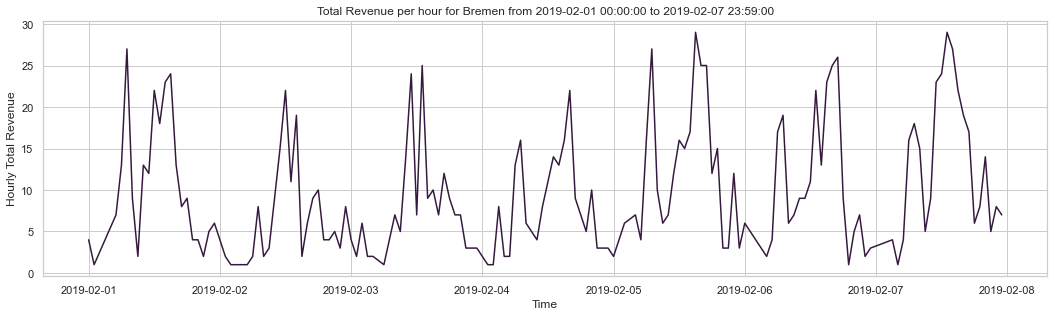

In [77]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", ci=None)
ax.set_title(f"Total Revenue per hour for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")

fig.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

#### Düsseldorf

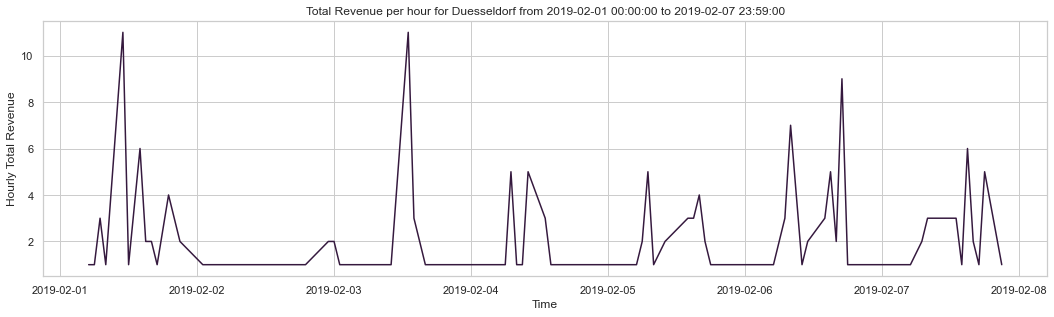

In [79]:
# create figure and axes
fig2, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.lineplot(ax=ax2, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", ci=None)
ax2.set_title(f"Total Revenue per hour for {city2} from {startDate} to {endDate}")
ax2.set_ylabel("Hourly Total Revenue")
ax2.set_xlabel("Time")

fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

### Total Revenue per Hour, averaged over the selected time interval and grouped over hours 0-24

#### Bremen

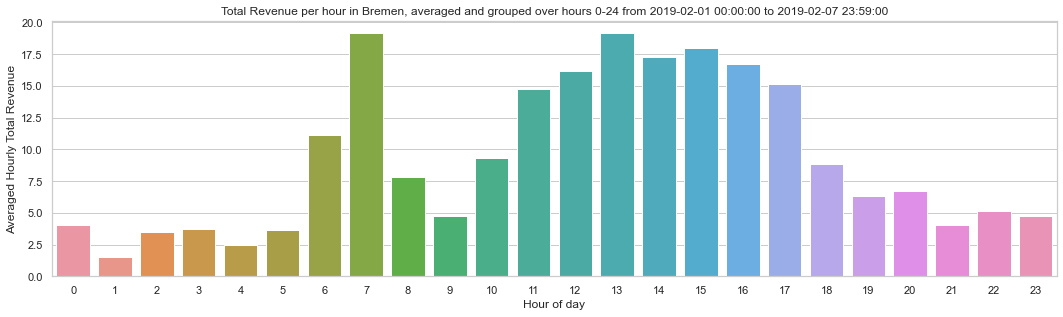

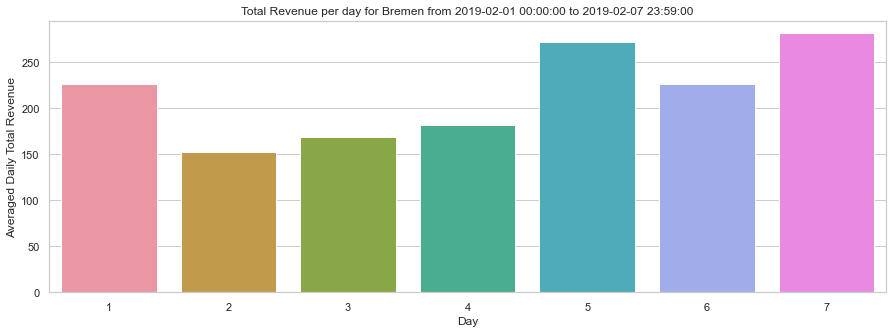

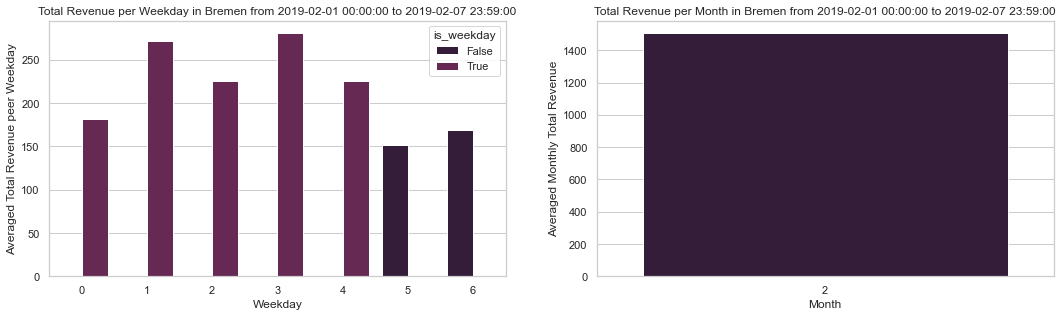

In [95]:
# create figure and axes
fig3, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax3, data=bremen_gr_hourly.reset_index(), x="hour", y="average_hourly_total_revenue", ci=None)
ax3.set_title(f"Total Revenue per hour in {city1}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
ax3.set_ylabel("Averaged Hourly Total Revenue")
ax3.set_xlabel("Hour of day")

fig3.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

# create figure and axes
fig4, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax4, data=bremen_gr_daily.reset_index(), x="day", y="daily_total_revenue", ci=None)
ax4.set_title(f"Total Revenue per day for {city1} from {startDate} to {endDate}")
ax4.set_ylabel("Averaged Daily Total Revenue")
ax4.set_xlabel("Day")

# create figure and axes
fig5, (ax5, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax5, data=bremen_gr_weekday.reset_index(), x="weekday", y="weekday_total_revenue", hue="is_weekday", ci=None)
ax5.set_title(f"Total Revenue per Weekday in {city1} from {startDate} to {endDate}")
ax5.set_ylabel("Averaged Total Revenue peer Weekday")
ax5.set_xlabel("Weekday")

# generate plots
sns.barplot(ax=ax6, data=bremen_gr_monthly.reset_index(), x="month", y="monthly_total_revenue", ci=None)
ax6.set_title(f"Total Revenue per Month in {city1} from {startDate} to {endDate}")
ax6.set_ylabel("Averaged Monthly Total Revenue")
ax6.set_xlabel("Month")

fig5.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

#### Düsseldorf

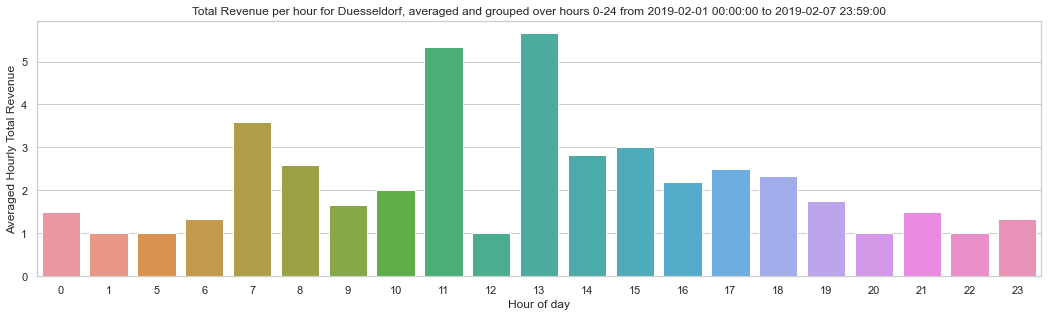

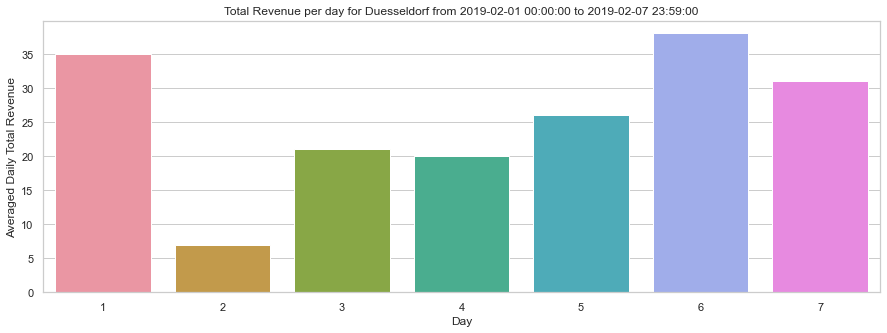

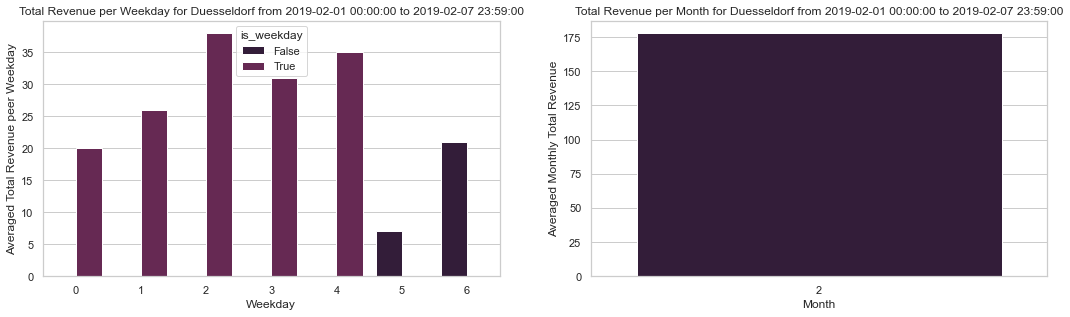

In [97]:
# create figure and axes
fig6, (ax6) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax6, data=duesseldorf_gr_hourly.reset_index(), x="hour", y="average_hourly_total_revenue", ci=None)
ax6.set_title(f"Total Revenue per hour for {city2}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
ax6.set_ylabel("Averaged Hourly Total Revenue")
ax6.set_xlabel("Hour of day")

fig6.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

# create figure and axes
fig7, (ax7) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax7, data=duesseldorf_gr_daily.reset_index(), x="day", y="daily_total_revenue", ci=None)
ax7.set_title(f"Total Revenue per day for {city2} from {startDate} to {endDate}")
ax7.set_ylabel("Averaged Daily Total Revenue")
ax7.set_xlabel("Day")

# create figure and axes
fig8, (ax8, ax9) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# generate plots
sns.barplot(ax=ax8, data=duesseldorf_gr_weekday.reset_index(), x="weekday", y="weekday_total_revenue", hue="is_weekday", ci=None)
ax8.set_title(f"Total Revenue per Weekday for {city2} from {startDate} to {endDate}")
ax8.set_ylabel("Averaged Total Revenue peer Weekday")
ax8.set_xlabel("Weekday")

# generate plots
sns.barplot(ax=ax9, data=duesseldorf_gr_monthly.reset_index(), x="month", y="monthly_total_revenue", ci=None)
ax9.set_title(f"Total Revenue per Month for {city2} from {startDate} to {endDate}")
ax9.set_ylabel("Averaged Monthly Total Revenue")
ax9.set_xlabel("Month")

fig8.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

In [139]:
plt.show()